# GeoCroissant Time-Series Support
- This notebook demonstrates how to convert a STAC ItemCollection to a GeoCroissant-compliant JSON-LD, validate it, and visualize the time-series geospatial data.

#  Convert STAC ItemCollection to GeoCroissant JSON-LD
- Description:
This cell defines utility functions and a main conversion function to transform a STAC ItemCollection into a GeoCroissant-compliant JSON-LD file. It aggregates spatial and temporal extents, collects all assets, and structures the data for time-series support.

In [1]:
import json
from datetime import datetime
import re

def sanitize_name(name):
    return re.sub(r"[^a-zA-Z0-9_\-]", "-", name)

def ensure_semver(version):
    if not version:
        return "1.0.0"
    if version.startswith("v"):
        version = version[1:]
    parts = version.split(".")
    if len(parts) == 2:
        parts.append("0")
    return ".".join(parts[:3])

def get_bbox_union(bboxes):
    # Union of all bounding boxes
    minx = min(b[0] for b in bboxes)
    miny = min(b[1] for b in bboxes)
    maxx = max(b[2] for b in bboxes)
    maxy = max(b[3] for b in bboxes)
    return [minx, miny, maxx, maxy]

def get_time_range(times):
    # Get min/max ISO8601 times
    times = [t for t in times if t]
    if not times:
        return None, None
    times = sorted(times)
    return times[0], times[-1]

def stac_itemcollection_to_geocroissant(stac_dict):
    features = stac_dict.get("features", [])
    if not features:
        raise ValueError("No features found in STAC ItemCollection.")

    # Aggregate spatial and temporal extents
    bboxes = []
    start_times = []
    end_times = []
    for feat in features:
        bbox = feat.get("bbox")
        if bbox:
            bboxes.append(bbox)
        props = feat.get("properties", {})
        # Try both 'datetime' and 'start_datetime'/'end_datetime'
        if "start_datetime" in props and "end_datetime" in props:
            start_times.append(props["start_datetime"])
            end_times.append(props["end_datetime"])
        elif "datetime" in props:
            start_times.append(props["datetime"])
            end_times.append(props["datetime"])

    # Use the first feature for some metadata
    first = features[0]
    dataset_id = stac_dict.get("id", first.get("collection", "UnnamedDataset"))
    name = sanitize_name(stac_dict.get("title", dataset_id))
    version = ensure_semver(stac_dict.get("version", "1.0.0"))

    croissant = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/geocroissant/",
            "dct": "http://purl.org/dc/terms/",
            "sc": "https://schema.org/",
            "citeAs": "cr:citeAs",
            "column": "cr:column",
            "conformsTo": "dct:conformsTo",
            "data": {"@id": "cr:data", "@type": "@json"},
            "dataBiases": "cr:dataBiases",
            "dataCollection": "cr:dataCollection",
            "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
            "extract": "cr:extract",
            "field": "cr:field",
            "fileProperty": "cr:fileProperty",
            "fileObject": "cr:fileObject",
            "fileSet": "cr:fileSet",
            "format": "cr:format",
            "includes": "cr:includes",
            "isLiveDataset": "cr:isLiveDataset",
            "jsonPath": "cr:jsonPath",
            "key": "cr:key",
            "md5": {"@id": "cr:md5", "@type": "sc:Text"},
            "sha256": {"@id": "cr:sha256", "@type": "sc:Text"},
            "parentField": "cr:parentField",
            "path": "cr:path",
            "personalSensitiveInformation": "cr:personalSensitiveInformation",
            "recordSet": "cr:recordSet",
            "references": "cr:references",
            "regex": "cr:regex",
            "repeated": "cr:repeated",
            "replace": "cr:replace",
            "separator": "cr:separator",
            "source": "cr:source",
            "subField": "cr:subField",
            "transform": "cr:transform"
        },
        "@type": "Dataset",
        "@id": dataset_id,
        "name": name,
        "description": stac_dict.get("description", ""),
        "version": version,
        "license": stac_dict.get("license", "CC-BY-4.0"),
        "conformsTo": "http://mlcommons.org/croissant/1.0"
    }

    # Add numberReturned if present
    if "numberReturned" in stac_dict:
        croissant["numberReturned"] = stac_dict["numberReturned"]

    # Links and references
    references = []
    for link in stac_dict.get("links", []):
        rel = link.get("rel")
        href = link.get("href")
        if not href or rel == "self":
            continue
        references.append({
            "@type": "CreativeWork",
            "url": href,
            "name": rel,
            "encodingFormat": link.get("type", "application/json")
        })
    if references:
        croissant["references"] = references

    # Spatial and temporal extent
    if bboxes:
        croissant["geocr:BoundingBox"] = get_bbox_union(bboxes)
    if start_times and end_times:
        start, end = get_time_range(start_times + end_times)
        croissant["dct:temporal"] = {"startDate": start, "endDate": end}
        croissant["datePublished"] = start
    else:
        croissant["datePublished"] = datetime.utcnow().isoformat() + "Z"

    # Distribution: all assets from all features
    croissant["distribution"] = []
    for feat in features:
        assets = feat.get("assets", {})
        for key, asset in assets.items():
            file_object = {
                "@type": "cr:FileObject",
                "@id": f"{feat['id']}/{key}",
                "name": f"{feat['id']}/{key}",
                "description": asset.get("description", asset.get("title", "")),
                "contentUrl": asset.get("href"),
                "encodingFormat": asset.get("type", "application/octet-stream"),
                "sha256": "https://github.com/mlcommons/croissant/issues/80",
                "md5": "https://github.com/mlcommons/croissant/issues/80"
            }
            croissant["distribution"].append(file_object)

    # Add a recordSet for time-series, with all per-item fields
    croissant["recordSet"] = []
    for feat in features:
        props = feat.get("properties", {})
        record = {
            "@type": "cr:RecordSet",
            "id": feat.get("id"),
            "datetime": props.get("datetime"),
            "start_datetime": props.get("start_datetime"),
            "end_datetime": props.get("end_datetime"),
            "bbox": feat.get("bbox"),
            "assets": list(feat.get("assets", {}).keys()),
            "geometry": feat.get("geometry"),
            "links": feat.get("links", []),
            "properties": props,
            "stac_version": feat.get("stac_version"),
            "stac_extensions": feat.get("stac_extensions", [])
        }
        croissant["recordSet"].append(record)

    # Optionally, add stac_extensions, stac_version, etc. at top level
    if "stac_extensions" in stac_dict:
        croissant["geocr:stac_extensions"] = stac_dict["stac_extensions"]
    if "stac_version" in stac_dict:
        croissant["geocr:stac_version"] = stac_dict["stac_version"]

    # Add citeAs if not present (recommended by Croissant)
    if "citeAs" not in croissant:
        croissant["citeAs"] = "Citation information not provided."

    # Report unmapped fields
    mapped_keys = {
        "type", "links", "features", "id", "title", "description", "license", "version", "stac_extensions", "stac_version", "numberReturned"
    }
    extra_fields = {k: v for k, v in stac_dict.items() if k not in mapped_keys}
    print("\n\033[1mUnmapped STAC Fields:\033[0m")
    if extra_fields:
        for k, v in extra_fields.items():
            print(f"- {k}: {type(v).__name__}")
    else:
        print("None ")

    return croissant

# === Main Runner ===
if __name__ == "__main__":
    # Load STAC ItemCollection JSON
    with open("stac.json") as f:
        stac_data = json.load(f)

    # Convert to GeoCroissant
    croissant_json = stac_itemcollection_to_geocroissant(stac_data)

    # Save GeoCroissant JSON-LD
    with open("croissant.json", "w") as f:
        json.dump(croissant_json, f, indent=2)

    print("\nGeoCroissant conversion complete. Output saved to 'croissant.json'")


Unmapped STAC Fields:
None 

GeoCroissant conversion complete. Output saved to 'croissant.json'


# Pretty Print the GeoCroissant Output
- Description:
This cell loads the generated croissant.json and prints it in a human-readable format for inspection.

In [2]:
import json

# Load and pretty-print the content of croissant.json
with open("croissant.json", "r") as f:
    croissant_data = json.load(f)

# Pretty-print JSON to console
print(json.dumps(croissant_data, indent=2))

{
  "@context": {
    "@language": "en",
    "@vocab": "https://schema.org/",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/geocroissant/",
    "dct": "http://purl.org/dc/terms/",
    "sc": "https://schema.org/",
    "citeAs": "cr:citeAs",
    "column": "cr:column",
    "conformsTo": "dct:conformsTo",
    "data": {
      "@id": "cr:data",
      "@type": "@json"
    },
    "dataBiases": "cr:dataBiases",
    "dataCollection": "cr:dataCollection",
    "dataType": {
      "@id": "cr:dataType",
      "@type": "@vocab"
    },
    "extract": "cr:extract",
    "field": "cr:field",
    "fileProperty": "cr:fileProperty",
    "fileObject": "cr:fileObject",
    "fileSet": "cr:fileSet",
    "format": "cr:format",
    "includes": "cr:includes",
    "isLiveDataset": "cr:isLiveDataset",
    "jsonPath": "cr:jsonPath",
    "key": "cr:key",
    "md5": {
      "@id": "cr:md5",
      "@type": "sc:Text"
    },
    "sha256": {
      "@id": "cr:sha256",
      "@type": "sc:Tex

# Validate the GeoCroissant JSON-LD
 - Description:
This cell uses the mlcroissant CLI tool to validate the generated GeoCroissant JSON-LD file for schema compliance.

In [3]:
!mlcroissant validate --jsonld=croissant.json

W0723 12:40:43.293839 126338195190144 rdf.py:80] WARNING: The JSON-LD `@context` is not standard. Refer to the official @context (e.g., from the example datasets in https://github.com/mlcommons/croissant/tree/main/datasets/1.0). The different keys are: {'examples', 'rai'}
I0723 12:40:43.361503 126338195190144 validate.py:53] Done.


# Batch Visualization of Raster and CSV Points
- Description:
This cell visualizes the raster (TIF) and point (CSV) data for each record in batches. Each subplot shows a raster image with overlaid training data points.

 Processing batch 1 (10 records)


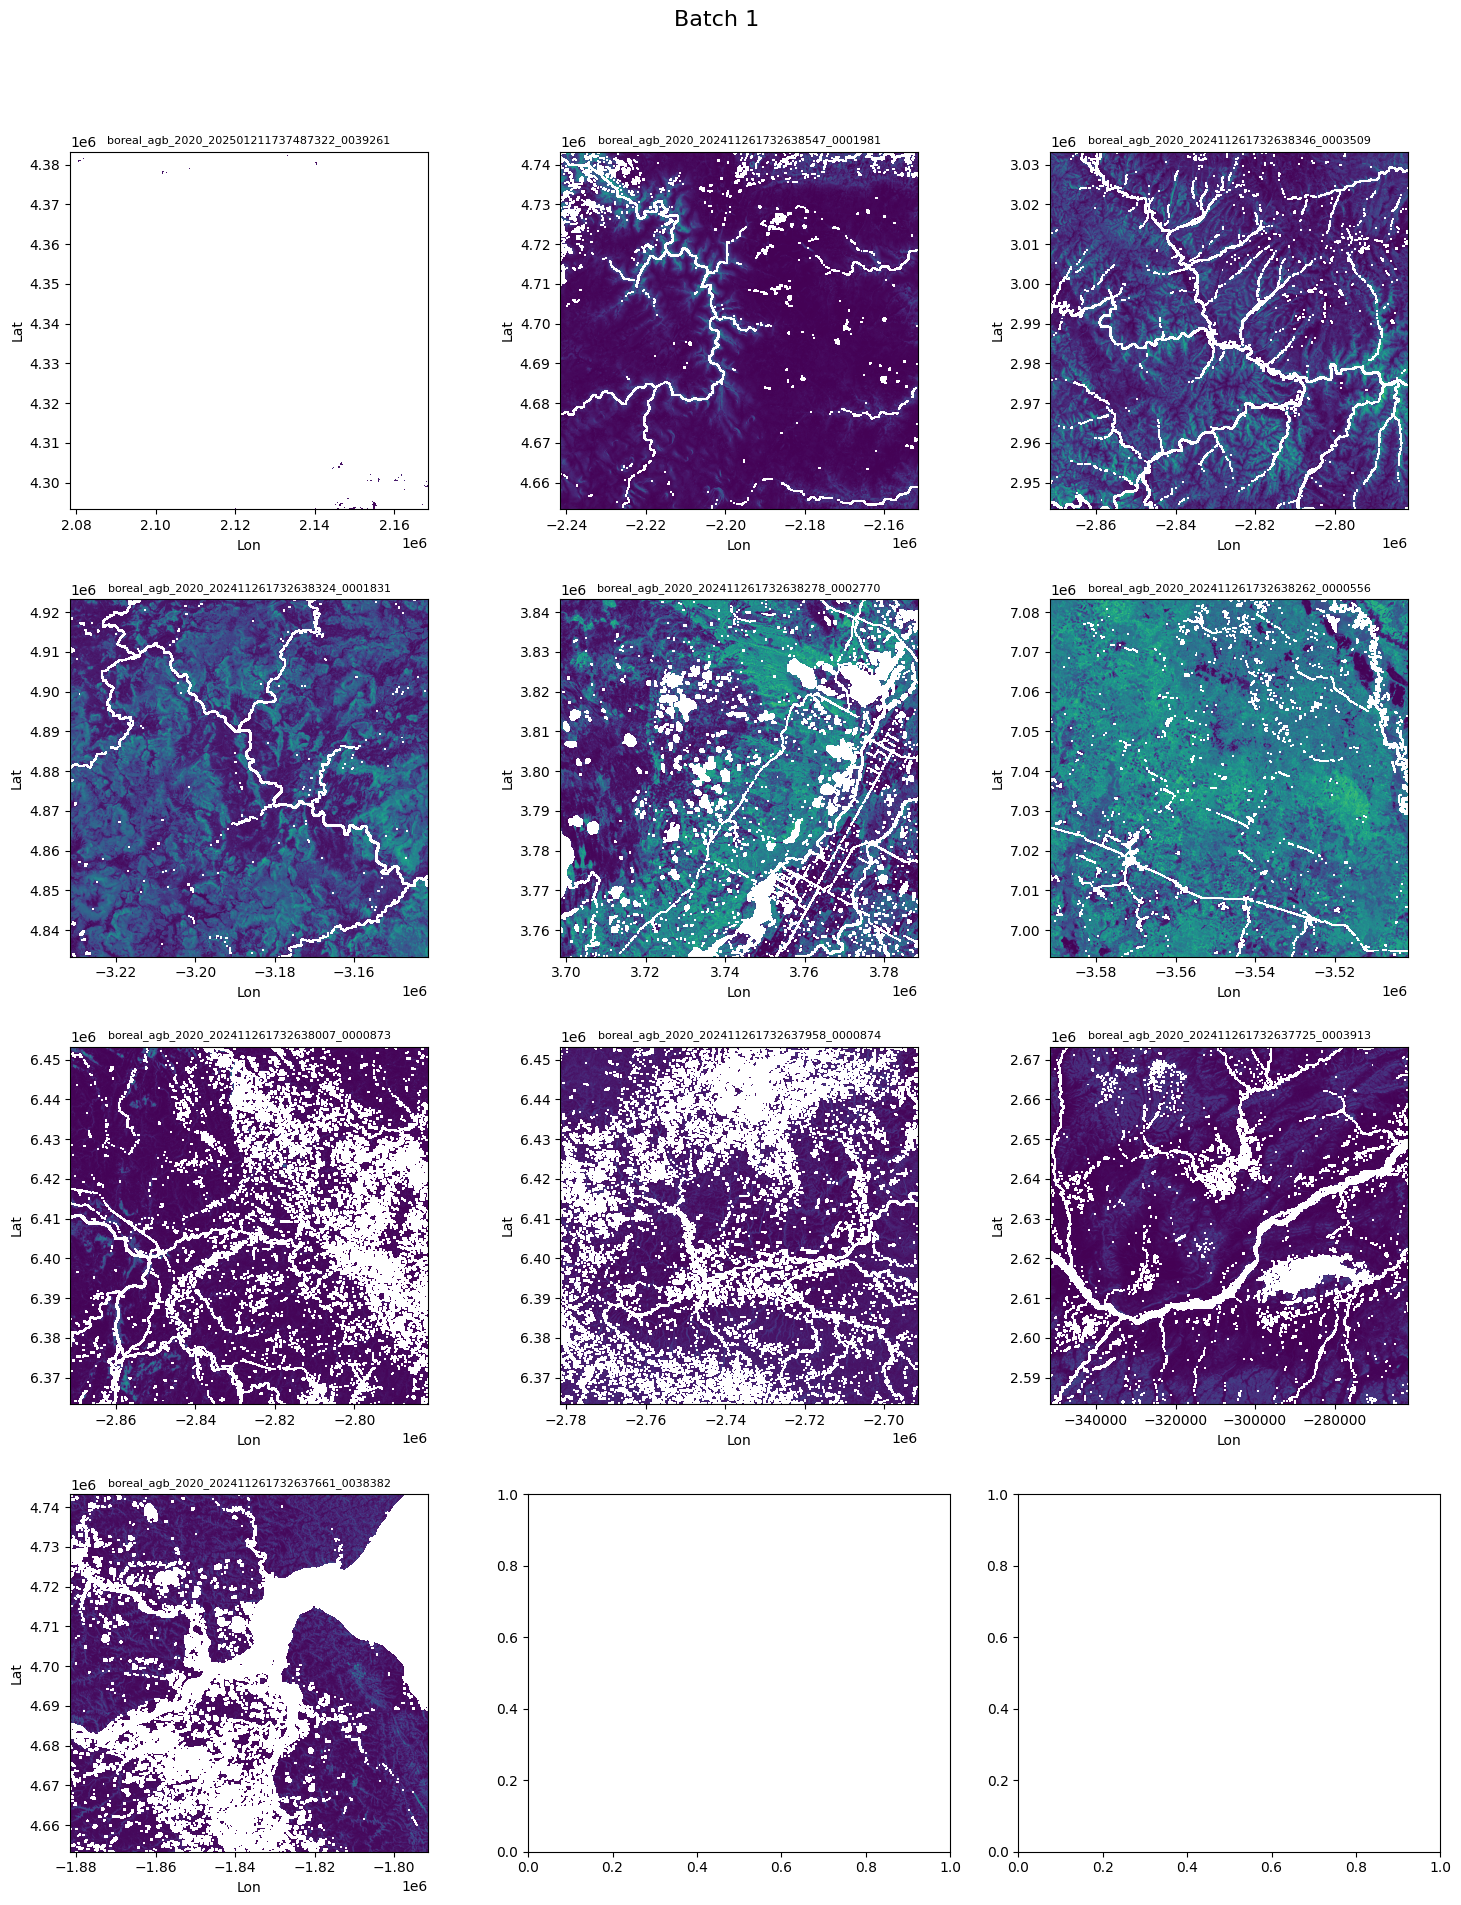

In [4]:
import os
import json
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

with open('croissant.json') as f:
    croissant = json.load(f)

records = croissant['recordSet']
distributions = croissant['distribution']

batch_size = 12  # because 3x3 grid

def get_asset(record_id, suffix):
    for a in distributions:
        if a['@id'].startswith(record_id) and a['@id'].endswith(suffix):
            return a['contentUrl']
    return None

def batch_iterable(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i+size]

for batch_num, batch in enumerate(batch_iterable(records, batch_size), start=1):
    print(f" Processing batch {batch_num} ({len(batch)} records)")

    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.flatten()

    for idx, record in enumerate(batch):
        ax = axes[idx]

        tif_url = get_asset(record['id'], 'cog')
        csv_url = get_asset(record['id'], 'training_data_csv')

        if not tif_url or not csv_url:
            print(f" Missing assets for record {record['id']}, skipping.")
            ax.axis('off')
            continue

        csv_url_http = csv_url.replace(
            "s3://nasa-maap-data-store/",
            "https://nasa-maap-data-store.s3.amazonaws.com/"
        )

        try:
            with rasterio.open(tif_url) as src:
                img = src.read(1)
                extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

            df = pd.read_csv(csv_url_http)

            ax.imshow(img, extent=extent, origin='upper', cmap='viridis')
            if {'longitude', 'latitude'}.issubset(df.columns):
                ax.scatter(df['longitude'], df['latitude'], c='red', s=10)
            ax.set_title(f"{record['id']}", fontsize=8)
            ax.set_xlabel('Lon')
            ax.set_ylabel('Lat')

        except Exception as e:
            print(f" Error processing record {record['id']}: {e}")
            ax.axis('off')

    # Turn off unused subplots
    for j in range(len(batch), 10):
        axes[j].axis('off')

    plt.suptitle(f"Batch {batch_num}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Overlay All Rasters and Points on a World Map
- Description:
This cell overlays all raster images and all training data points on a single world map using Cartopy, providing a global overview of the dataset coverage.

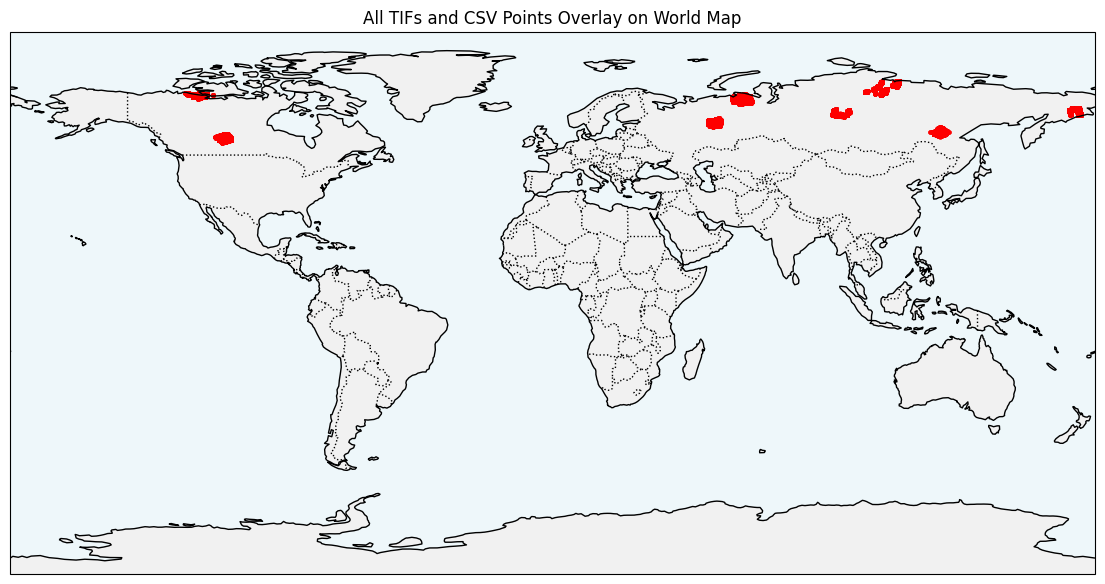

In [5]:
import os
import json
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

with open('croissant.json') as f:
    croissant = json.load(f)

all_imgs = []
all_extents = []
all_points = []

for record in croissant['recordSet']:
    tif_asset = [
        a for a in croissant['distribution']
        if a['@id'].startswith(record['id']) and a['@id'].endswith('cog')
    ][0]
    tif_url = tif_asset['contentUrl']

    csv_asset = [
        a for a in croissant['distribution']
        if a['@id'].startswith(record['id']) and a['@id'].endswith('training_data_csv')
    ][0]
    csv_url = csv_asset['contentUrl']
    csv_url_http = csv_url.replace("s3://nasa-maap-data-store/", "https://nasa-maap-data-store.s3.amazonaws.com/")

    # Read raster
    with rasterio.open(tif_url) as src:
        img = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        all_imgs.append((img, extent))

    # Read CSV
    df = pd.read_csv(csv_url_http)
    if {'longitude', 'latitude'}.issubset(df.columns):
        all_points.append((df['longitude'].values, df['latitude'].values))
    elif {'lon', 'lat'}.issubset(df.columns):
        all_points.append((df['lon'].values, df['lat'].values))

# Plot all rasters and all points on a world map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Overlay all rasters (with some transparency)
for img, extent in all_imgs:
    ax.imshow(img, extent=extent, origin='upper', cmap='viridis', alpha=0.3, transform=ccrs.PlateCarree())

# Overlay all points
for lons, lats in all_points:
    ax.scatter(lons, lats, c='red', s=5, alpha=0.5, label='Training Data', transform=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('All TIFs and CSV Points Overlay on World Map')
plt.show()